# How good is each scenario at clustering?
| Matrix Type | Precision Matrix | Precision Matrix (Negatives) | Covariance Matrix
| --- | --- | --- | --- |
| EiGLasso Nonparanormal | ? | ? | ? |
| antGLasso (heuristic) Nonparanormal | ? | ? | ? |
| EiGLasso | ? | ? | ? |
| antGLasso (heuristic) | ? | ? | ? |
| antGLasso | ? | ? | ? |

## Load the data

In [1]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import glob
from rpy2.robjects.packages import importr
from rpy2.robjects import globalenv
import rpy2.robjects.numpy2ri
import rpy2.robjects.pandas2ri
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

In [ ]:
from Scripts.antGLasso import antGLasso, antGLasso_heuristic
from Scripts.anBiGLasso import calculate_empirical_covariances
from Scripts.EiGLasso import EiGLasso_cov

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
splatter = importr("splatter")
base = importr("base")
scuttle = importr("scuttle")
BiocSingular = importr("BiocSingular")
BiocGenerics = importr("BiocGenerics")
igraph = importr("igraph")
TSP = importr("TSP")
stats = importr("stats")
Revelio = importr("Revelio")

In [5]:
class REXPR():
    def __init__(self, r_object):
        self.r_object = r_object
        
    def __getitem__(self, idxs: (tuple, str)):
        if isinstance(idxs, str):
            # If just passed a single index, don't
            # split it up in characters!
            return REXPR(self.r_object.slots[idxs])
        # Recursively iterate over every index
        temp = self.r_object
        for idx in idxs:
            temp = temp.slots[idx]
        return REXPR(temp)
    
    @property
    def slots(self):
        return list(self.r_object.slots)
    
    def __repr__(self):
        return f"[REXPR]: {repr(self.r_object)}"
    
    def __getattr__(self, attrname):
        return base.__dict__["$"](self.r_object, attrname)

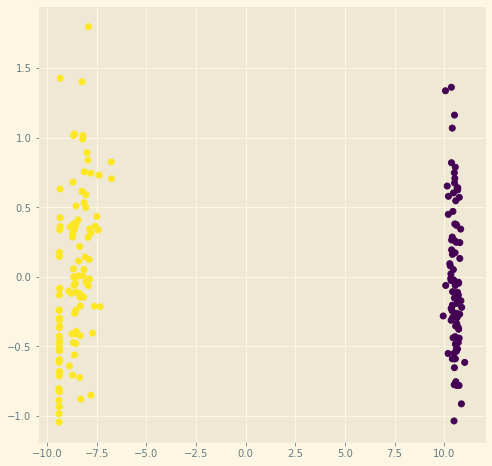

In [11]:
num_cells = 200
params_groups = splatter.newSplatParams(batchCells = num_cells, nGenes = 10)
args = (
    ("params", params_groups),
    ("de.prob", 1),
    ("de.facLoc", 5),
    ("path.from", base.c(0)),
    ("path.nSteps", 2),
    ("dropout.type", "none"),
    ("verbose", False)
)
sim1 = splatter.splatSimulatePaths.rcall(args, globalenv)
sim1 = scuttle.logNormCounts(sim1)
sc_data = REXPR(sim1)
log_counts = np.array(sc_data['assays', 'data'].logcounts)
pcad_vals = PCA(n_components=2).fit_transform(log_counts.T)
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(*pcad_vals.T, c=np.array(sc_data['colData'].Step))

## Analyze clustering capabilities

In [15]:
samples = 1
noise = np.random.random((samples, *log_counts.shape)) / 1000
empirical = calculate_empirical_covariances((log_counts + noise))
nonpara = nonparanormal_tensor_skeptic((log_counts + noise))
data = log_counts + noise

In [16]:
Psis_eig_nonpara = EiGLasso_cov(
    T = nonpara[0],
    S = nonpara[1],
    beta_1=0,
    beta_2=0,
)
Psis_eig_empirical = EiGLasso_cov(
    T = empirical[0],
    S = empirical[1],
    beta_1=0,
    beta_2=0,
)
Psis_ant_nonpara = antGLasso_heuristic(
    nonpara,
    sparsities=[1, 1],
    B_approx_iters=5000
)
Psis_ant_empirical = antGLasso_heuristic(
    empirical,
    sparsities=[1, 1],
    B_approx_iters=5000
)
Psis_ant_exact = antGLasso(
    data,
    sparsities=[1, 1],
    B_approx_iters=5000
)

In [51]:
true_labels = np.array(sc_data['colData'].Step, dtype=int)-1
def get_accuracy(x):
    # We take the max b/c the cluster labels might be in opposite
    # order (i.e. "cluster 1" could be labeled as "cluster 2" since
    # there's no natural ordering.)
    return max(
        (x.labels_ == true_labels).sum(),
        (x.labels_ != true_labels).sum()
    ) / len(true_labels)

clustering_eig_nonpara_precmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(Psis_eig_nonpara[1]))
clustering_eig_nonpara_precmat_neg = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.maximum(-np.abs(Psis_eig_nonpara[1]), 0) + 0.0000001)
clustering_eig_nonpara_covmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.linalg.inv(Psis_eig_nonpara[1]))

clustering_eig_empirical_precmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(Psis_eig_empirical[1]))
clustering_eig_empirical_precmat_neg = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.maximum(-np.abs(Psis_eig_empirical[1]), 0) + 0.0000001)
clustering_eig_empirical_covmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.linalg.inv(Psis_eig_empirical[1]))

clustering_ant_nonpara_precmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(Psis_ant_nonpara[1]))
clustering_ant_nonpara_precmat_neg = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.maximum(-np.abs(Psis_ant_nonpara[1]), 0) + 0.0000001)
clustering_ant_nonpara_covmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(np.linalg.inv(Psis_ant_nonpara[1])))

clustering_ant_empirical_precmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(Psis_ant_empirical[1]))
clustering_ant_empirical_precmat_neg = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.maximum(-np.abs(Psis_ant_empirical[1]), 0) + 0.0000001)
clustering_ant_empirical_covmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(np.linalg.inv(Psis_ant_empirical[1])))

clustering_ant_exact_precmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(Psis_ant_exact[1]))
clustering_ant_exact_precmat_neg = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.maximum(-np.abs(Psis_ant_exact[1]), 0) + 0.0000001)
clustering_ant_exact_covmat = SpectralClustering(
    n_clusters=2,
    assign_labels='discretize',
    random_state=0,
    affinity='precomputed'
).fit(np.abs(np.linalg.inv(Psis_ant_exact[1])))

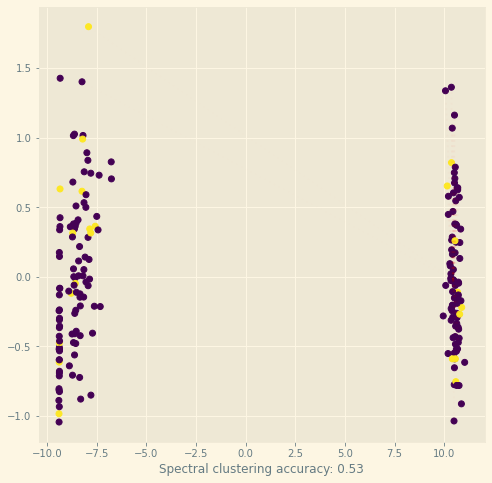

In [57]:
# TEST
with plt.style.context('Solarize_Light2'):
    figtest, axtest = plt.subplots(figsize=(8, 8))
    plot_precision_neg(
        Psis_ant_empirical,
        idx,
        get_accuracy(clustering_ant_empirical_precmat_neg),
        axtest
    )
    axtest.scatter(*new_pca, c=clustering_eig_nonpara_precmat_neg.labels_)

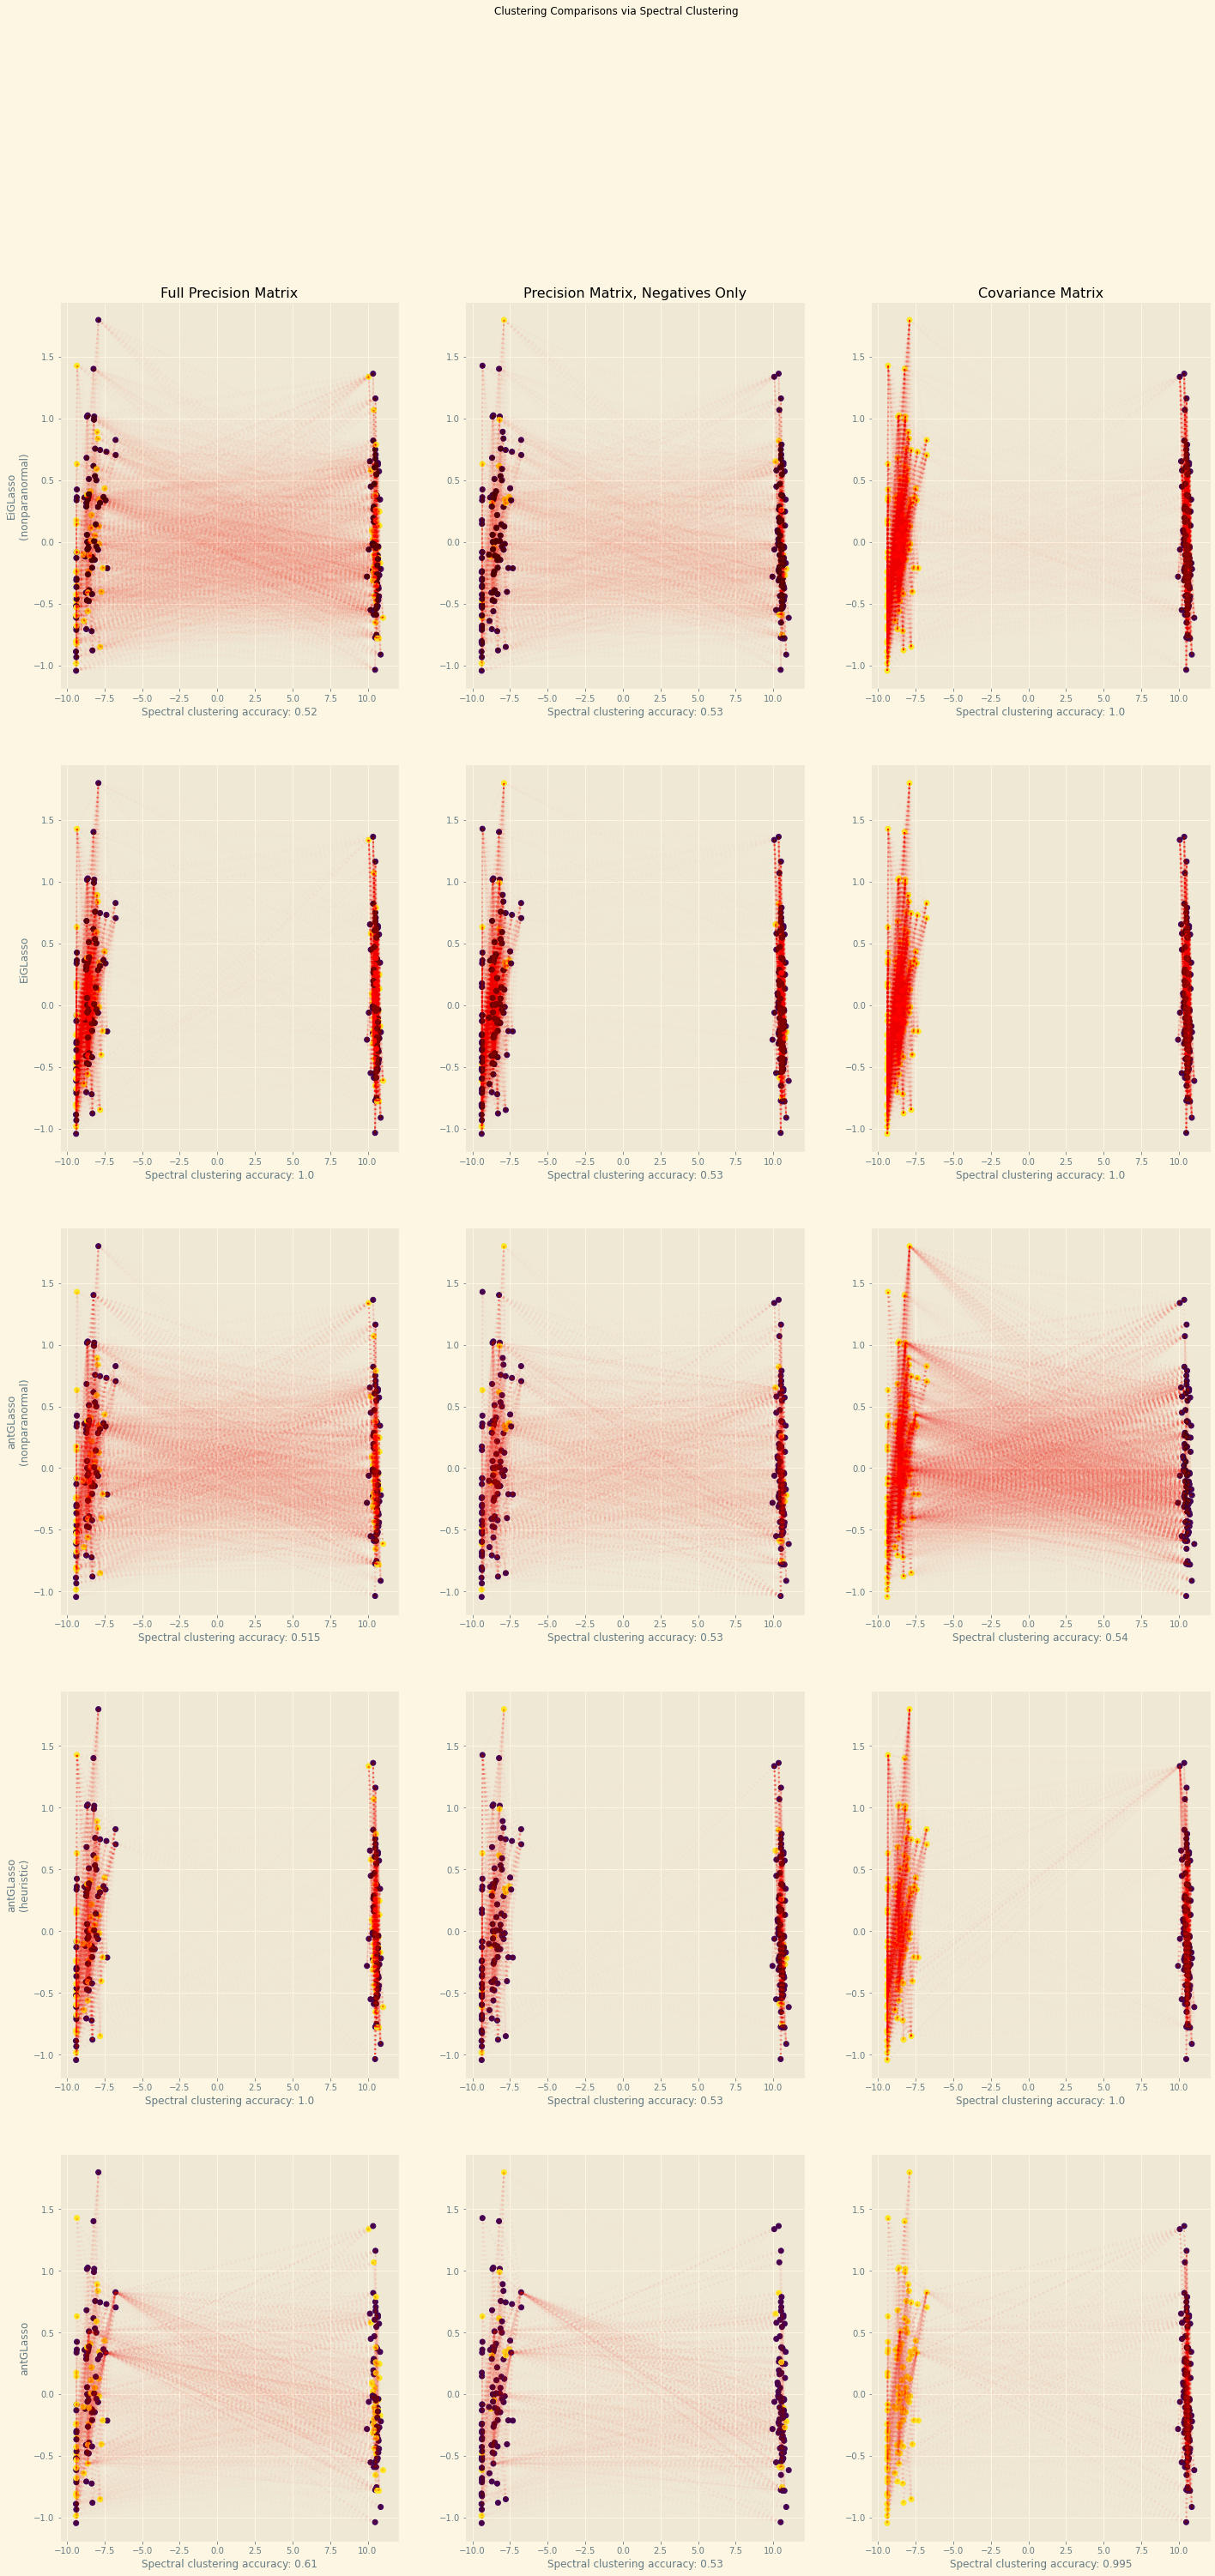

In [53]:
def plot_precision(Psis, idx, acc, ax, strength=0.05):
    connections = np.abs(Psis[1][idx])
    connections[idx] = 0 # set diagonal to zero
    max_connect = connections.max()
    for idx2, link in enumerate(connections):
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, strength*link / max_connect), linestyle=':')
    ax.set_xlabel(f"Spectral clustering accuracy: {acc}")
    
def plot_precision_neg(Psis, idx, acc, ax, strength=0.05):
    connections = -Psis[1][idx]#np.abs(cov_mat[idx])
    connections[idx] = 0 # set diagonal to zero
    max_connect = connections.max()
    for idx2, link in enumerate(connections):
        x2, y2 = pcad_vals[idx2]
        if link < 0:
            # i.e. if it was a nonnegative value in original precision matrix
            # then we ignore its connections!
            continue
        ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, strength*link / max_connect), linestyle=':')
    ax.set_xlabel(f"Spectral clustering accuracy: {acc}")
    
def plot_covariance(covmat, idx, acc, ax, strength=0.05):
    connections = np.abs(covmat[idx])
    connections[idx] = 0 # set diagonal to zero
    max_connect = connections.max()
    for idx2, link in enumerate(connections):
        x2, y2 = pcad_vals[idx2]
        ax.plot([x1, x2], [y1, y2], color=(1, 0, 0, strength*link / max_connect), linestyle=':')
    ax.set_xlabel(f"Spectral clustering accuracy: {acc}")

with plt.style.context('Solarize_Light2'):
    fig, (
        (ax11, ax12, ax13),
        (ax21, ax22, ax23),
        (ax31, ax32, ax33),
        (ax41, ax42, ax43),
        (ax51, ax52, ax53),
    ) = plt.subplots(figsize=(24, 48), ncols=3, nrows=5)
    
    cov_mat_eig_nonpara = np.linalg.inv(Psis_eig_nonpara[1])
    cov_mat_eig_empirical = np.linalg.inv(Psis_eig_empirical[1])
    cov_mat_ant_nonpara = np.linalg.inv(Psis_ant_nonpara[1])
    cov_mat_ant_empirical = np.linalg.inv(Psis_ant_empirical[1])
    cov_mat_ant_exact = np.linalg.inv(Psis_ant_exact[1])
    for idx, (x1, y1) in enumerate(pcad_vals):
        
        # Column Headers
        ax11.set_title("Full Precision Matrix")
        ax12.set_title("Precision Matrix, Negatives Only")
        ax13.set_title("Covariance Matrix")
        
        # Row Headers
        ax11.set_ylabel("EiGLasso\n(nonparanormal)")
        ax21.set_ylabel("EiGLasso")
        ax31.set_ylabel("antGLasso\n(nonparanormal)")
        ax41.set_ylabel("antGLasso\n(heuristic)")
        ax51.set_ylabel("antGLasso")
        
        ## EiGLasso Nonparanormal Precision
        plot_precision(
            Psis_eig_nonpara,
            idx,
            get_accuracy(clustering_eig_nonpara_precmat),
            ax11,
            0.01
        )
            
        ## EiGLasso Nonparanormal Precision Negatives Only
        plot_precision_neg(
            Psis_eig_nonpara,
            idx,
            get_accuracy(clustering_eig_nonpara_precmat_neg),
            ax12,
            0.01
        )
            
        ## EiGLasso Nonparanormal Covariance
        plot_covariance(
            cov_mat_eig_nonpara,
            idx,
            get_accuracy(clustering_eig_nonpara_covmat),
            ax13,
            0.01
        )
        
        ## EiGLasso Precision
        plot_precision(
            Psis_eig_empirical,
            idx,
            get_accuracy(clustering_eig_empirical_precmat),
            ax21,
            0.01
        )
            
        ## EiGLasso Precision Negatives Only
        plot_precision_neg(
            Psis_eig_empirical,
            idx,
            get_accuracy(clustering_eig_empirical_precmat_neg),
            ax22,
            0.01
        )
            
        ## EiGLasso Covariance
        plot_covariance(
            cov_mat_eig_empirical,
            idx,
            get_accuracy(clustering_eig_empirical_covmat),
            ax23,
            0.01
        )
        
        ## antGLasso Nonparanormal Precision
        plot_precision(
            Psis_ant_nonpara,
            idx,
            get_accuracy(clustering_ant_nonpara_precmat),
            ax31
        )
            
        ## antGLasso Nonparanormal Precision Negatives Only
        plot_precision_neg(
            Psis_ant_nonpara,
            idx,
            get_accuracy(clustering_ant_nonpara_precmat_neg),
            ax32
        )
            
        ## antGLasso Nonparanormal Covariance
        plot_covariance(
            cov_mat_ant_nonpara,
            idx,
            get_accuracy(clustering_ant_nonpara_covmat),
            ax33
        )
        
        ## antGLasso Heuristic Precision
        plot_precision(
            Psis_ant_empirical,
            idx,
            get_accuracy(clustering_ant_empirical_precmat),
            ax41
        )
            
        ## antGLasso Heuristic Precision Negatives Only
        plot_precision_neg(
            Psis_ant_empirical,
            idx,
            get_accuracy(clustering_ant_empirical_precmat_neg),
            ax42
        )
            
        ## antGLasso Heuristic Covariance
        plot_covariance(
            cov_mat_ant_empirical,
            idx,
            get_accuracy(clustering_ant_empirical_covmat),
            ax43
        )
        
        ## antGLasso Precision
        plot_precision(
            Psis_ant_exact,
            idx,
            get_accuracy(clustering_ant_exact_precmat),
            ax51
        )
            
        ## antGLasso Precision Negatives Only
        plot_precision_neg(
            Psis_ant_exact,
            idx,
            get_accuracy(clustering_ant_exact_precmat_neg),
            ax52
        )
            
        ## antGLasso Covariance
        plot_covariance(
            cov_mat_ant_exact,
            idx,
            get_accuracy(clustering_ant_exact_covmat),
            ax53
        )

        
    new_pca = PCA(n_components=2).fit_transform(data[0].T).T
    ax11.scatter(*new_pca, c=clustering_eig_nonpara_precmat.labels_)
    ax12.scatter(*new_pca, c=clustering_eig_nonpara_precmat_neg.labels_)
    ax13.scatter(*new_pca, c=clustering_eig_nonpara_covmat.labels_)
    
    ax21.scatter(*new_pca, c=clustering_eig_nonpara_precmat.labels_)
    ax22.scatter(*new_pca, c=clustering_eig_nonpara_precmat_neg.labels_)
    ax23.scatter(*new_pca, c=clustering_eig_nonpara_covmat.labels_)
    
    ax31.scatter(*new_pca, c=clustering_eig_nonpara_precmat.labels_)
    ax32.scatter(*new_pca, c=clustering_eig_nonpara_precmat_neg.labels_)
    ax33.scatter(*new_pca, c=clustering_eig_nonpara_covmat.labels_)
    
    ax41.scatter(*new_pca, c=clustering_eig_nonpara_precmat.labels_)
    ax42.scatter(*new_pca, c=clustering_eig_nonpara_precmat_neg.labels_)
    ax43.scatter(*new_pca, c=clustering_eig_nonpara_covmat.labels_)
    
    ax51.scatter(*new_pca, c=clustering_eig_nonpara_precmat.labels_)
    ax52.scatter(*new_pca, c=clustering_eig_nonpara_precmat_neg.labels_)
    ax53.scatter(*new_pca, c=clustering_eig_nonpara_covmat.labels_)
    
    fig.savefig("../../Plots/Fundamental Barriers/Clustering Comparison")